In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
'''ONLY FOR VISUALIZATION'''
import pandas as pd 
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
#Modify DATA_PATH if needed
DATA_TRAIN_PATH = '../../data_project1/train.csv'
y, tX_old, ids = load_csv_data(DATA_TRAIN_PATH)

In [40]:
'''DATASET INTRINSICS AND SHAPE (TARGETS AND IDS INCLUDED)'''
def DataSetInfo(y, tX_old, ids):
    print("Training examples: ", tX_old, " & shape: ")
    print("Targets: ", y)
    print("Ids: ",ids)
    print("Shapes of tX, y & Ids: ", tX_old.shape, y.shape, ids.shape)

'''INITIALIZE WEIGHTS WITH RANDOM VALUES'''
def InitWeights(feat):
    ww = np.random.rand(feat)
    #ww = np.zeros((feat))
    init_w = np.array(ww, dtype=np.float64)
    return init_w

'''HYPER PARAMETERS'''
def HyperParameters():
    max_iter = 500
    epochs = 5
    gamma = 1e-2
    lambda_ = 1e-2
    decay = 1e-2
    k_fold = 10
    return max_iter, epochs, gamma, lambda_, decay, k_fold

'''DECREASE LEARNING RATE AT EVERY EPOCH'''
def GammaScheduler(gamma, decay, epoch):
    gamma = gamma * (1/(1 + decay * epoch))
    return gamma

'''TAKE LOG TRANSFORMATION OF FEATURES'''
def LogTransformData(tX, features):  
    data = tX[:, features]
    indices = np.where(data > -999)
    data[indices] = np.log(1 + data[indices])
    tX = ManipulateFeatures(tX, data, features)    
    return tX

'''DELETE GIVEN FEATURE VECTOR FROM FEATURE AND CONCETENATE WITH NEW DATA '''
def ManipulateFeatures(tX, data,features):
    tX = np.delete(tX, features, 1)
    return np.hstack((tX, data))

'''IMPUTE DATA WITH MEANS'''
def ImputeData(tX):
    tX = np.where(tX == -999, np.nan, tX)
    #Remove all columns with NAN
    tX = tX[:, ~np.all(np.isnan(tX), axis=0)]
    #Remove highly correlated features
    tX = tX[:, ~np.all(tX[1:] == tX[:-1], axis=0)]
    #Find Mean excluding NAN values
    tX_mean = np.nanmean(tX, axis=0)
    # NAN = MEAN
    tX[np.where(np.isnan(tX))] = np.take(tX_mean, np.where(np.isnan(tX))[1])
    print(tX.shape)
    return tX

'''STANDARDIZE'''
def Standardize(tX):
    mean_x = np.mean(tX, axis=0)
    tX = tX - mean_x
    std_x = np.std(tX, axis=0)
    tX[:, std_x > 0] = tX[:, std_x > 0] / std_x[std_x > 0]
    return tX, mean_x, std_x

'''PREPROCESS'''
def PreProcess(tX, rr_ = True):
    '''FEATURES PICKED BY HAND FOR LOG TRANSFORM'''
    log_feature_vec = np.array(([0, 2, 5, 9, 13, 16, 19, 21, 23, 26, 29]))
    tX = LogTransformData(tX, log_feature_vec)
    print(tX.shape)
    tX = ImputeData(tX)
    if rr_:
        tX = Standardize(tX)[0]
        tX = AddFeatures(tX)
    else:
        tX = AddFeatures(tX)
        tX = Standardize(tX)[0]
    return tX

'''DATASET SEPERATED IN TERMS OF CATEGORIES IN COLUMN 22'''
def Categorize_Train(y, tX, ids):
    '''CATEGORY 2 AND 3 CONCETENATED'''
    ind = [[] for j in range(3)]
    xx = [[] for j in range(3)]
    yy = [[] for j in range(3)]
    iids = [[] for j in range(3)]
    
    for i in range(3): 
        ind[i] = np.nonzero(tX[:, 22] == i)[0]
        if i == 2:
            ind[i] = np.hstack((ind[i], np.nonzero(tX[:, 22] == (i+1))[0].T))       
        xx[i] = tX[ind[i]]
        yy[i] = y[ind[i]]
        iids[i] = ids[ind[i]]
        
    return np.array((yy)), np.array((xx)), np.array((iids)), np.array((ind))

'''CATEGORIZE TEST'''
def Categorize_Test(tX, ids):
    '''CATEGORY 2 AND 3 CONCETENATED'''
    ind = [[] for j in range(3)]
    xx = [[] for j in range(3)]
    iids = [[] for j in range(3)]
    
    for i in range(3): 
        ind[i] = np.nonzero(tX[:, 22] == i)[0]
        if i == 2:
            ind[i] = np.hstack((ind[i], np.nonzero(tX[:, 22] == (i+1))[0].T))   
        xx[i] = tX[ind[i]]
        iids[i] = ids[ind[i]]
        
    return np.array((xx)), np.array((iids)), np.array((ind))

'''PREDICTIONS INTO COMPARABLE FORM'''
def Decategorize(y_cat, ind):
    size = y_cat[0].shape[0] + y_cat[1].shape[0] + y_cat[2].shape[0]
    y = np.zeros((size,), dtype=np.float)
    for i in range(len(y_cat)):
        y[ind[i]] = y_cat[i]
    return y

'''CHECK VALIDATION SCORE'''
def WeightedAverage(pred, target):
    total_count = pred[0].shape[0] + pred[1].shape[0] + pred[2].shape[0]
    true_count = 0
    for i in range(3):
        true_count +=  np.sum(pred[i] == target[i])
    acc = true_count / total_count
    return acc
'''FEATURE CORRELATION MAP: ONLY FOR VISUALIZATION'''
'''CORRELATED FEATURES: CORR > THRESHOLD : USE FOR SYNTHESIS'''
def CorrMap(tX):
    df = pd.DataFrame(tX)
    f = plt.figure(figsize=(19, 15))
    corr = df.corr()
    plt.matshow(corr, fignum=f.number, cmap=plt.cm.get_cmap('coolwarm'))
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

'''RANDOM DATA SPLIT'''
def RandomizedDataSplit(tX, y, ids, inds, split_size = 0.1, my_seed=1):
    '''SET SEED FOR REMOVING RANDOMNESS'''
    #np.random.seed(my_seed)
    '''RANDOM INDEXES'''
    size = y.shape[0]
    ind = np.random.permutation(size)
    split = int(np.floor(split_size * size))
    
    ind_train = ind[split:]
    ind_valid = ind[:split]
    
    
    '''SPLIT DATA ACCORDING TO RANDOM INDICES'''
    tX_train = tX[ind_train]
    tX_valid = tX[ind_valid]
    y_train = y[ind_train]
    y_valid = y[ind_valid]
    ids_train = ids[ind_train]
    ids_valid = ids[ind_valid]
    inds_train = inds[ind_train]
    inds_valid = inds[ind_valid]
    
    print("Shapes of tX, y, Ids & Indices for Training: ", tX_train.shape, y_train.shape, ids_train.shape, inds_train.shape)
    print("Shapes of tX, y, Ids & Indices for Validation: ", tX_valid.shape, y_valid.shape, ids_valid.shape, inds_valid.shape)
    return (tX_train, y_train, ids_train, inds_train),(tX_valid, y_valid, ids_valid, inds_valid)

'''BACKWARD SELECTION METHOD FOR BEST FEATURE SELECTION: GREEDY APPROACH'''
def BackwardSelection(y, tX, tX_valid, y_valid, model = "RR"):
    
    selected_features = []
    cur_best_acc = 0
    improved = True     
    while improved:
        improved = False
        worst_ft = -1 
        for i in range(tX.shape[1]):
            if i not in selected_features:
                
                diff = set(list(range(tX.shape[1]))) - set(selected_features + [i])            
                #calculate accuracy
                #print(tX[:,list(diff)].shape,y.shape)
                
                cur_acc = CrossValidation(y, tX[:,list(diff)],10)
                #print(cur_acc)
                #accuracy is improved
                if cur_best_acc <= cur_acc:
                    #print("best so far: ",cur_best_acc)
                    improved = True
                    cur_best_acc = cur_acc
                    worst_ft = i                    
        if improved:
            selected_features.append(worst_ft)  
        #print("burada",improved)
            
    return list(set(list(range(tX.shape[1]))) - set(selected_features )), cur_best_acc

'''FORWARD OF BACKWARD SELECTION'''
def Selection(y, tX, tX_valid, y_valid, typ = "BS", model = "RR"):
    if typ == "BS":
        selected_features, cur_best_acc = BackwardSelection(y, tX, tX_valid, y_valid,model)
        return selected_features, cur_best_acc
    elif typ == "FS":
        selected_features, cur_best_acc = ForwardSelection(y, tX, tX_valid, y_valid,model) 
        return selected_features, cur_best_acc
    
'''FORWARD SELECTION METHOD FOR BEST FEATURE SELECTION: GREEDY APPROACH'''
def ForwardSelection(y, tX, tX_valid, y_valid, model = "RR"):    
    selected_features = []
    cur_best_acc = 0  
    improved = True
    while improved:
        
        improved = False
        best_ft = -1 
        for i in range(tX.shape[1]):
            if i not in selected_features: 
                #calculate accuracy             
                cur_acc = CrossValidation(y, tX[:,selected_features+[i]],5)
                #print(cur_acc)
                #accuracy is improved
                if cur_best_acc <= cur_acc:
                    improved = True                   
                    cur_best_acc = cur_acc
                    best_ft = i                 
                    
        if improved:
            selected_features.append(best_ft)
            #print(selected_features)
         
    return selected_features, cur_best_acc

'''ADD NEW FUTURES'''
def AddFeatures(tX):
    prime_numbers = [2,3]
    #ADD COS / SIN , SQRT 
    #CHECK FEATURE SYNTHESIS
    pm = 0
    loop_count = tX.shape[1]
    for i in range(loop_count):
            tX = np.hstack((tX, np.cos(tX[:,i]).reshape(-1,1)))
    for i in range(loop_count):
            tX = np.hstack((tX, np.sin(tX[:,i]).reshape(-1,1)))
                
    for pm in range(len(prime_numbers)):
        for i in range(3*loop_count):
            tX = np.hstack((tX, np.power(tX[:,i], prime_numbers[pm]).reshape(-1,1)))
    
    return tX

'''CROSS VALIDATION HELPER FUNCTION'''
def SelectIndices(y, k_fold, seed):
    row_count = y.shape[0]
    window_size = int((row_count / k_fold))
    remainder = row_count % k_fold
    '''SEED IN TERMS OF SHUFFLING ONLY ONCE'''
    np.random.seed(seed)
    rand_indices = np.random.permutation(row_count)
    indices = [[] for i in range(k_fold)]
    
    for k in range(k_fold):
        
            indices[k] = np.array((rand_indices[k*window_size:(k+1)*window_size]))
            
    return np.array(indices)
'''CROSS VALIDATION'''
def CrossValidation(y, tX, k, cat_, lambda_):
    seed = np.random.randint(10)
    indices = SelectIndices(y,k,seed)
    average_acc = 0
    w_vec = list()
    
    for i in range (k): 
        tr_indices = list()
        count = 1
        for tr_ in range(len(indices)):
            if i != tr_:
                if count == 1:
                    tr_indices = np.array((indices[tr_]))
                    count += 1
                else:
                    tr_indices = np.hstack((tr_indices, indices[tr_]))
                
        #print(tr_indices)
        valid_indices = indices[i]   
        xk_train = tX[tr_indices]
        xk_valid = tX[valid_indices]
        yk_train = y[tr_indices]
        yk_valid = y[valid_indices]
        #print(yk_train.shape,xk_train.shape)
        #print(xk_valid.shape)
        init_w_gd = np.array((InitWeights(xk_train.shape[1])))
        
        start = timeit.default_timer()
        
        (w,loss) = ridge_regression(yk_train, xk_train,lambda_)
        
                
        stop = timeit.default_timer()
        print('Time: ', stop - start) 
        
        ls_tr_pred = predict_labels(w, xk_valid)
        average_acc += (ls_tr_pred == yk_valid).mean()/k
        w_vec.append(w)
        
    print("Cross Validation Accuracy for Category ",cat_,": ",average_acc)
    w_final = w_vec[0]
    for weight in range(1,len(w_vec)):
        w_final += w_vec[weight]
    w_final = w_final / len(w_vec)
    
    return w_final, average_acc
    
'''BUILD FULL DATA MODEL WITH CATEGORIZATION'''
def BuildDataModel_Train(y, tX_old, ids, pp = False):
    y_cat, tX_cat, id_cat, ind_cat = Categorize_Train(y, tX_old, ids)  
    for cat_ in range(tX_cat.shape[0]):
        tX_cat[cat_] = PreProcess(tX_cat[cat_], pp)  
         
    '''TRAIN SET'''
    tX_tr_cat = [[] for j in range(3)]
    y_tr_cat = [[] for j in range(3)]
    id_tr_cat = [[] for j in range(3)]
    ind_tr_cat = [[] for j in range(3)]

    '''VALID SET'''
    tX_val_cat = [[] for j in range(3)]
    y_val_cat = [[] for j in range(3)]
    id_val_cat = [[] for j in range(3)]
    ind_val_cat = [[] for j in range(3)]

    for i in range(len(tX_cat)):
        (tX_tr_cat[i], y_tr_cat[i],id_tr_cat[i],ind_tr_cat[i]), (tX_val_cat[i], y_val_cat[i],id_val_cat[i], ind_val_cat[i]) = RandomizedDataSplit(tX_cat[i], y_cat[i], id_cat[i], ind_cat[i])

    '''CONVERT TRAIN AND DATASET INTO NUMPY ARRAYS'''
    tX_tr_cat = np.array((tX_tr_cat))
    y_tr_cat = np.array((y_tr_cat))
    id_tr_cat = np.array((id_tr_cat))
    ind_tr_cat = np.array((ind_tr_cat))

    tX_val_cat = np.array((tX_val_cat))
    y_val_cat = np.array((y_val_cat))
    id_val_cat = np.array((id_val_cat))
    ind_val_cat = np.array((ind_val_cat))

    return (y_tr_cat, tX_tr_cat, id_tr_cat, ind_tr_cat), (y_val_cat, tX_val_cat, id_val_cat, ind_val_cat)

'''CROSS VALIDATION DATA MODEL'''
def BuildDataModel_CV(y, tX_old, ids):
    y_cat, tX_cat, id_cat, ind_cat = Categorize_Train(y, tX_old, ids)
    
    for cat_ in range(tX_cat.shape[0]): 
        tX_cat[cat_] = PreProcess(tX_cat[cat_], True)
        
    return y_cat, tX_cat, id_cat, ind_cat


'''BUILD FULL DATA MODEL WITH CATEGORIZATION'''
def BuildDataModel_Test(tX_old, ids, pp = False):
    tX_cat, id_cat, ind_cat = Categorize_Test(tX_old, ids)
    
    for cat_ in range(tX_cat.shape[0]):
        tX_cat[cat_] = PreProcess(tX_cat[cat_], pp)
        
    '''CONVERT TRAIN AND DATASET INTO NUMPY ARRAYS'''
    tX_cat = np.array((tX_cat))
    id_cat = np.array((id_cat))
    ind_cat = np.array((ind_cat))
    
    return tX_cat, id_cat, ind_cat

'''BUILD FULL DATA MODEL WITH CATEGORIZATION -> FOR RIDGE REGRESSION AND LEAST SQUARES'''
def BuildDataModel_CV_Test(tX_old, ids):
    tX_cat, id_cat, ind_cat = Categorize_Test(tX_old, ids)
    
    for cat_ in range(tX_cat.shape[0]):
        tX_cat[cat_] = PreProcess(tX_cat[cat_])
        
    '''CONVERT TRAIN AND DATASET INTO NUMPY ARRAYS'''
    tX_cat = np.array((tX_cat))
    id_cat = np.array((id_cat))
    ind_cat = np.array((ind_cat))
    
    return tX_cat, id_cat, ind_cat

In [4]:
def Categorize_Lucky(y, tX, ids):
    ind = [[] for j in range(2)]
    xx = [[] for j in range(2)]
    yy = [[] for j in range(2)]
    iids = [[] for j in range(2)]
    
    ind[0] = np.nonzero(tX[:, 29] <= 0.1)[0]      
    xx[0] = tX[ind[0]]
    yy[0] = y[ind[0]]
    iids[0] = ids[ind[0]]
    
    ind[1] = np.nonzero(tX[:, 29] > 0.1)[0]      
    xx[1] = tX[ind[1]]
    yy[1] = y[ind[1]]
    iids[1] = ids[ind[1]]
        
    return np.array((yy)), np.array((xx)), np.array((iids)), np.array((ind))



'''CATEGORIZE TEST'''
def Categorize_Lucky_Test(tX, ids):
    '''CATEGORY 2 AND 3 CONCETENATED'''
    ind = [[] for j in range(2)]
    xx = [[] for j in range(2)]
    iids = [[] for j in range(2)]
    
    ind[0] = np.nonzero(tX[:, 29] <= 0.1)[0]      
    xx[0] = tX[ind[0]]
    iids[0] = ids[ind[0]]
    
    ind[1] = np.nonzero(tX[:, 29] > 0.1)[0]      
    xx[1] = tX[ind[1]]
    iids[1] = ids[ind[1]]
        
    return np.array((xx)), np.array((iids)), np.array((ind))

'''CROSS VALIDATION DATA MODEL'''
def BuildDataModel_Lucky(y, tX_old, ids):
    y_cat, tX_cat, id_cat, ind_cat = Categorize_Lucky(y, tX_old, ids)
    
    for cat_ in range(tX_cat.shape[0]): 
        tX_cat[cat_] = PreProcess(tX_cat[cat_], True)
        
    return y_cat, tX_cat, id_cat, ind_cat

def BuildDataModel_Lucky_Test(tX_old, ids):
    tX_cat, id_cat, ind_cat = Categorize_Lucky_Test(tX_old, ids)
    
    for cat_ in range(tX_cat.shape[0]):
        tX_cat[cat_] = PreProcess(tX_cat[cat_])
        
    '''CONVERT TRAIN AND DATASET INTO NUMPY ARRAYS'''
    tX_cat = np.array((tX_cat))
    id_cat = np.array((id_cat))
    ind_cat = np.array((ind_cat))
    
    return tX_cat, id_cat, ind_cat

'''PREDICTIONS INTO COMPARABLE FORM'''
def Decategorize_Lucky(y_cat, ind):
    size = y_cat[0].shape[0] + y_cat[1].shape[0]
    y = np.zeros((size,), dtype=np.float)
    for i in range(len(y_cat)):
        y[ind[i]] = y_cat[i]
    return y

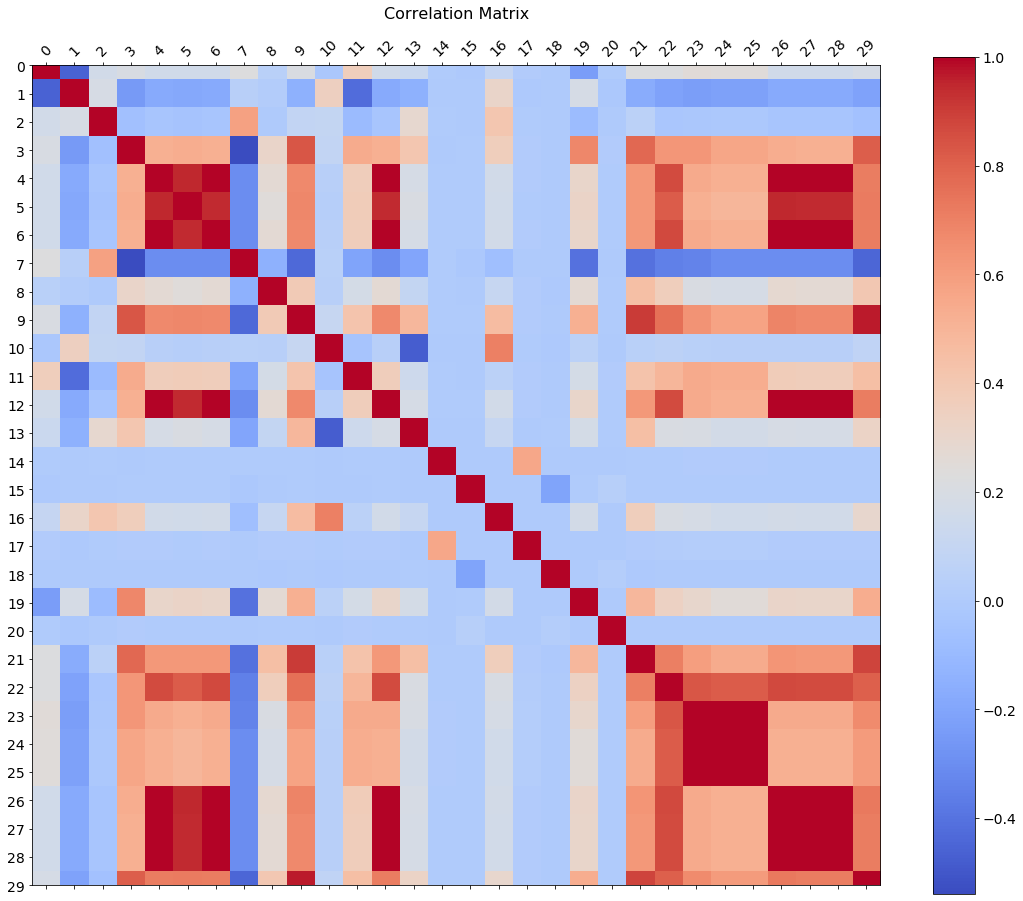

In [17]:
CorrMap(tX_old)
plt.savefig('results.png')

## Do your thing crazy machine learning thing here :) ...

In [6]:
'''GRAD AND LOSS FUNCTIONS'''
def compute_loss(y, tx, w, typ):
    '''typ = <LOSS_TYPE(WITH CAPITAL LETTERS)>'''
    loss = 0
    N = y.shape[0]
    if typ == "MSE":
        loss = (1/(2*N))*np.sum(np.square(y - (tx@w)))        
    elif typ == "MAE":
        loss = (1/(2*N))*np.sum(np.abs(y - (tx@w)))
    return loss

def compute_gradient(y, tx, w):
    '''GRADIENT COMPUTATION'''
    N = y.shape[0]
    e = y - tx@w
    grad = (-1/N) * (tx.T@e)
    return grad

def compute_stoch_gradient(y, tx, w):
    '''STOCHASTIC GRADIENT DESCENT GRADIENT COMPUTATION''' 
    N = y.shape[0]
    e = y - tx@w
    grad = (-1/N)*(tx.T@e)
    return grad

def compute_ls_loss(y, tx, w):
    '''LEAST SQUARES WITH NORMAL EQUATIONS LOSS COMPUTATION'''
    loss = 0
    N = y.shape[0]
    loss = (1/(2*N))*(tx.T@(y - tx@w))
    
def compute_rdg_loss(y, tx, w, lambda_):
    '''RIDGE REGRESSION LOSS COMPUTATION'''
    loss = 0
    N = y.shape[0]
    loss = (1/(2*N))*np.sum(np.square(y - (tx@w))) + (lambda_*np.sum(w.T@w))
    return loss

def sigmoid(tx, w):
    '''SIGMOID CALCULATION'''
    z = 1 / (1 + np.exp(-1*(tx@w)))
    return z

def compute_log_loss(y, tx, w):
    '''LOGISTIC LOSS'''
    loss = 0;
    sigm = sigmoid(tx,w)
    sigm2 = 1 - sigm
    N = y.shape[0]
    '''GIVEN THAT WE HAVE A VALUE THAT IS NEGATIVE OR REALLY SMALL(PYTHON CONVERTS IT TO ZERO DURING COMPUTATION)'''
    '''CONVERT THEM TO 1e-100'''
    sigm[sigm < 1e-50] = 1e-50
    sigm2[sigm2 < 1e-50] = 1e-50
    
    loss = (-1/N)*np.sum(y.T@np.log(sigm) + ((1-y).T@np.log(sigm2)))
    
    return loss
def compute_log_gradient(y, tx, w):
    '''GRADIENT COMPUTATION FOR LR'''
    N = y.shape[0]
    z = sigmoid(tx,w)
    grad = (1/N) * (tx.T@(z - y))
    return grad

def compute_reg_log_loss(y, tx, w, lambda_):
    '''LOGISTIC LOSS WITH REGULARIZATION'''
    loss = 0;
    sigm = sigmoid(tx,w)
    sigm2 = 1 - sigm
    N = y.shape[0]
    sigm[sigm < 1e-50] = 1e-50
    sigm2[sigm2 < 1e-50] = 1e-50
    loss = (-1/N)*(np.sum(y.T@np.log(sigm) + ((1-y).T@np.log(sigm2))) + ((lambda_/2)*np.sum(w.T@w)))
    
    return loss
def compute_reg_log_gradient(y, tx, w, lambda_):
    '''GRADIENT COMPUTATION FOR LR WITH REGULARIZATION'''
    N = y.shape[0]
    z = sigmoid(tx,w)
    grad = (1/N) * ((tx.T@(z - y)) + (lambda_*w))
    return grad

In [25]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    '''BATCH GRADIENT DESCENT'''
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w, "MSE")
        grad = compute_gradient(y, tx, w)
        w = w - (gamma * grad)
        if (n_iter % 100) == 0:
            print("Batch Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))

    return (w, loss)

In [26]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    '''STOCHASTIC GRADIENT DESCENT'''
    w = initial_w 
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, 1):
            loss = compute_loss(minibatch_y, minibatch_tx, w, "MSE")
            grad = compute_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * grad
            if (n_iter % 100) == 0:
                print("Stochastic Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))
                
    return (w, loss)

In [9]:
def least_squares(y, tx):
    '''COMPUTE W_STAR: WEIGHT FOR NORMAL EQUATIONS BY LINEAR EQUATION SOLVER'''
    w_star = np.linalg.solve(tx.T@tx, tx.T@y)
    loss = compute_ls_loss(y, tx, w_star)
    return (w_star,loss)

In [10]:
def ridge_regression(y, tx, lambda_):
    '''RIDGE REGRESSION WITH LAMBDA PARAMETER AS REGULARIZATION PARAMETER'''
    N = y.shape[0]
    a = tx.shape[0]
    m = (tx.T@tx)+(lambda_/(2*N))*np.identity(tx.shape[1])
    i = np.eye(m.shape[0],m.shape[0])
    w_ridge = np.linalg.lstsq(m,i)[0]@tx.T@y
    loss = compute_rdg_loss(y, tx, w_ridge, lambda_)
    return (w_ridge, loss)
    

In [11]:
def logistic_regression(y, tx, initial_w, max_iters, gamma, mod = 1):
    if mod == 1:
        '''FOR GRADIENT DESCENT'''
        w = initial_w
        for n_iter in range(max_iters):
            loss = compute_log_loss(y, tx, w)
            grad = compute_log_gradient(y, tx, w)
            w = w - (gamma * grad)
            if (n_iter % 100) == 0:
                print("Logistic Regression Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))

        return (w, loss)
    else:
        '''FOR STOCHASTIC GRADIENT DESCENT'''
        w = initial_w 
        for n_iter in range(max_iters):
            for minibatch_y, minibatch_tx in batch_iter(y, tx, 1):
                loss = compute_log_loss(minibatch_y, minibatch_tx, w)
                grad = compute_log_gradient(minibatch_y, minibatch_tx, w)
                w = w - gamma * grad
                print("Logistic Regression Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))
        return (w, loss)

In [12]:
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma, mod = 1):
    if mod == 1:
        '''FOR GRADIENT DESCENT'''
        w = initial_w
        for n_iter in range(max_iters):
            loss = compute_reg_log_loss(y, tx, w, lambda_)
            grad = compute_reg_log_gradient(y, tx, w, lambda_)
            w = w - (gamma * grad)
            if (n_iter % 100) == 0:
                print("Logistic Regression Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))

        return (w, loss)
    else:
        '''FOR STOCHASTIC GRADIENT DESCENT'''
        w = initial_w 
        for n_iter in range(max_iters):
            for minibatch_y, minibatch_tx in batch_iter(y, tx, 1):
                loss = compute_reg_log_loss(minibatch_y, minibatch_tx, w, lambda_)
                grad = compute__reg_log_gradient(minibatch_y, minibatch_tx, w, lambda_)
                w = w - gamma * grad
                print("Logistic Regression Gradient Descent({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))
        return (w, loss)

## Generate predictions and save ouput in csv format for submission:

In [13]:
DATA_TEST_PATH = '../../data_project1/test.csv' # TODO: download train data and supply path here 
_, tX_test_old, ids_test = load_csv_data(DATA_TEST_PATH)

In [14]:
(y_cat, tX_cat, ids_cat, ind_cat), (y_val_cat, tX_val_cat, ids_val_cat, ind_val_cat) = BuildDataModel_Train(y,tX_old,ids)

(99913, 30)
(99913, 18)
(77544, 30)
(77544, 22)
(72543, 30)
(72543, 30)
Shapes of tX, y, Ids & Indices for Training:  (89922, 162) (89922,) (89922,) (89922,)
Shapes of tX, y, Ids & Indices for Validation:  (9991, 162) (9991,) (9991,) (9991,)
Shapes of tX, y, Ids & Indices for Training:  (69790, 198) (69790,) (69790,) (69790,)
Shapes of tX, y, Ids & Indices for Validation:  (7754, 198) (7754,) (7754,) (7754,)
Shapes of tX, y, Ids & Indices for Training:  (65289, 270) (65289,) (65289,) (65289,)
Shapes of tX, y, Ids & Indices for Validation:  (7254, 270) (7254,) (7254,) (7254,)


In [15]:
y_cv_cat, tX_cv_cat, ids_cv_cat, ind_cv_cat = BuildDataModel_CV(y,tX_old,ids)

(99913, 30)
(99913, 18)
(77544, 30)
(77544, 22)
(72543, 30)
(72543, 30)


In [20]:
tX_test_cat, id_test_cat, ind_test_cat = BuildDataModel_Test(tX_test_old,ids_test)

(227458, 30)
(227458, 18)
(175338, 30)
(175338, 22)
(165442, 30)
(165442, 30)


In [17]:
tX_cv_test_cat, id_cv_test_cat, ind_cv_test_cat = BuildDataModel_CV_Test(tX_test_old,ids_test)

(227458, 30)
(227458, 18)
(175338, 30)
(175338, 22)
(165442, 30)
(165442, 30)


In [ ]:
y_lucky, tX_lucky, ids_lucky, ind_lucky = BuildDataModel_Lucky(y, tX_old, ids)
tX_test_lucky, ids_test_lucky, ind_test_lucky = BuildDataModel_Lucky_Test(tX_test_old, ids_test)

In [42]:
'''PREDICTIONS FOR MODELS'''
def Main(y_cat, tX_cat, y_val_cat, tX_val_cat, mod = 1):
    init_w_gd = np.array((InitWeights(tX_cat[0].shape[1]),InitWeights(tX_cat[1].shape[1]),InitWeights(tX_cat[2].shape[1])))
    gd_tr_pred = np.copy((y_val_cat))
    w_gd = np.copy((init_w_gd))
    max_iters, epochs, gamma, lambda_,decay,k_fold = HyperParameters()
    cat_lst = [0, 1, 2]
    
    if mod == 1:
        for epoch_ in range(epochs):

            start = timeit.default_timer()

            for cat_ in cat_lst:   
                (w_gd[cat_],loss1) = least_squares_GD(y_cat[cat_], tX_cat[cat_],w_gd[cat_], max_iters, gamma)

            stop = timeit.default_timer()

            print('Time: ', stop - start) 

            gamma = GammaScheduler(gamma, decay, epoch_)
    
    elif mod == 2: 
        
         for epoch_ in range(epochs):

            start = timeit.default_timer()
            gamma = 1e-6
            for cat_ in cat_lst:   
                (w_gd[cat_],loss1) = least_squares_SGD(y_cat[cat_], tX_cat[cat_],w_gd[cat_], max_iters, gamma)

            stop = timeit.default_timer()

            print('Time: ', stop - start) 

            gamma = GammaScheduler(gamma, decay, epoch_)
            
    elif mod == 3: 
        print("Modifying Data in terms of Least Square with Normal Equations: ")
        (y_cat, tX_cat, ids_cat, ind_cat), (y_val_cat, tX_val_cat, ids_val_cat, ind_val_cat) = BuildDataModel_Train(y,tX_old,ids, True)
        for cat_ in cat_lst:   
            (w_gd[cat_],loss1) = least_squares(y_cat[cat_], tX_cat[cat_])

    elif mod == 4: 
        print("Modifying Data in terms of Ridge Regression: ")
        (y_cat, tX_cat, ids_cat, ind_cat), (y_val_cat, tX_val_cat, ids_val_cat, ind_val_cat) = BuildDataModel_Train(y,tX_old,ids,True)
        for cat_ in cat_lst:   
            (w_gd[cat_],loss1) = ridge_regression(y_cat[cat_], tX_cat[cat_],lambda_)
            
    elif mod == 5:
        
         for epoch_ in range(epochs):

            start = timeit.default_timer()

            for cat_ in cat_lst:   
                (w_gd[cat_],loss1) = logistic_regression(y_cat[cat_], tX_cat[cat_],w_gd[cat_], max_iters, gamma)

            stop = timeit.default_timer()

            print('Time: ', stop - start) 

            gamma = GammaScheduler(gamma, decay, epoch_)
            
    elif mod == 6:
        
         for epoch_ in range(epochs):

            start = timeit.default_timer()

            for cat_ in cat_lst:   
                (w_gd[cat_],loss1) = reg_logistic_regression(y_cat[cat_], tX_cat[cat_], lambda_, w_gd[cat_], max_iters, gamma)

            stop = timeit.default_timer()

            print('Time: ', stop - start) 

            gamma = GammaScheduler(gamma, decay, epoch_)
            
    '''PREDICTIONS'''
    for cat_ in cat_lst:
        gd_tr_pred[cat_] = predict_labels(w_gd[cat_], tX_val_cat[cat_])
        print(gd_tr_pred[cat_])
            
    acc = WeightedAverage(gd_tr_pred, y_val_cat)
    print("Accuracy of Model:", acc)
    return w_gd
w_normal = Main(y_cat, tX_cat, y_val_cat, tX_val_cat, 3)
print(w_normal.shape)

Modifying Data in terms of Least Square with Normal Equations: 
(99913, 30)
(99913, 18)
(77544, 30)
(77544, 22)
(72543, 30)
(72543, 30)
Shapes of tX, y, Ids & Indices for Training:  (89922, 162) (89922,) (89922,) (89922,)
Shapes of tX, y, Ids & Indices for Validation:  (9991, 162) (9991,) (9991,) (9991,)
Shapes of tX, y, Ids & Indices for Training:  (69790, 198) (69790,) (69790,) (69790,)
Shapes of tX, y, Ids & Indices for Validation:  (7754, 198) (7754,) (7754,) (7754,)
Shapes of tX, y, Ids & Indices for Training:  (65289, 270) (65289,) (65289,) (65289,)
Shapes of tX, y, Ids & Indices for Validation:  (7254, 270) (7254,) (7254,) (7254,)
[-1. -1. -1. ... -1. -1. -1.]
[-1. -1. -1. ...  1. -1. -1.]
[-1. -1.  1. ... -1. -1. -1.]
Accuracy of Model: 0.8330733229329174
(3,)


In [37]:
'''CROSS VALIDATION WEIGHT'''
'''WEIGHTS ARE TAKEN AS MEAN OF VARIOUS MEANS BY TRAINING ON DIFFERENT TRAIN-VALID PARTITIONS'''
'''ACCURACY INCREASE IS NOT THE PURPOSE BUT WEIGHT AND ACCURACY VALIDATION ARE FIXED'''
def CV_Main(y_cat, tX_cat):
    cat_lst = [0, 1, 2]
    max_iters, epochs, gamma, lambda_, decay, k_fold = HyperParameters()
    w_res = np.array((InitWeights(tX_cat[0].shape[1]),InitWeights(tX_cat[1].shape[1]),InitWeights(tX_cat[2].shape[1])))
    cv_tr_pred = [[] for i in range(len(cat_lst))]
    
    start = timeit.default_timer()
    
    for cat_ in cat_lst:
        w_final, avg_acc = CrossValidation(y_cat[cat_], tX_cat[cat_], k_fold, cat_, lambda_)
        w_res[cat_] = w_final
        print("Final weight vector shape: ",w_final.shape)
    
    return w_res


w_cv = CV_Main(y_cv_cat, tX_cv_cat)
print(w_cv.shape)

/anaconda3/envs/OneForAll/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


Time:  0.21613094200006344
Time:  0.16891151400000126
Time:  0.15705730599995604
Time:  0.16859648899992408
Time:  0.16014828200002285
Time:  0.16123707500003093
Time:  0.18487671599996247
Time:  0.17134030100010023
Time:  0.22082723500000156
Time:  0.15406353000003037
Cross Validation Accuracy for Category  0 :  0.8446902211990791
Final weight vector shape:  (162,)
Time:  0.2076896339999621
Time:  0.1710015740000017
Time:  0.1878645570000117
Time:  0.1903910089999954
Time:  0.208216425000046
Time:  0.21647392499994567
Time:  0.18992375499999525
Time:  0.17027726199989957
Time:  0.22369461599998886
Time:  0.20938806200001636
Cross Validation Accuracy for Category  1 :  0.8075960794428683
Final weight vector shape:  (198,)
Time:  0.4373655099999496
Time:  0.30840390399998796
Time:  0.3874000020000494
Time:  0.40737449999994624
Time:  0.382200801999943
Time:  0.345293622999975
Time:  0.30413582599999245
Time:  0.41619155899991256
Time:  0.3440808960000368
Time:  0.3074385570000686
Cross 

In [ ]:
def Lucky_Main(y_cat, tX_cat):
    cat_lst = [0, 1]
    max_iters, epochs, gamma, lambda_, decay, k_fold = HyperParameters()
    w_res = np.array((InitWeights(tX_cat[0].shape[1]),InitWeights(tX_cat[1].shape[1])))
    cv_tr_pred = [[] for i in range(len(cat_lst))]
    for cat_ in cat_lst:
        w_final, avg_acc = CrossValidation(y_cat[cat_], tX_cat[cat_], k_fold, cat_, lambda_)
        w_res[cat_] = w_final
        print("Final weight vector shape: ",w_final.shape)
    return w_res


w_lucky = Lucky_Main(y_lucky, tX_lucky)

In [38]:
'''FUNCTION FOR TESTING'''
'''DECATEGORIZES PREDICTIONS AFTER PREDICTIONS'''
def Tester(w_cv, tX_test_cat, id_test_cat, ind_test_cat, mod = 1):
    OUTPUT_PATH = 'results'+ str(mod)+'.csv'
    cat_lst = [0, 1, 2]
    y_pred = [[] for i in range(3)]
    for cat_ in cat_lst:
        y_pred[cat_] = predict_labels(w_cv[cat_], tX_test_cat[cat_])
    y_pred = np.array((y_pred))
    pred_vec = Decategorize(y_pred, ind_test_cat)
    pred_ids = Decategorize(id_test_cat, ind_test_cat)
    create_csv_submission(pred_ids, pred_vec, OUTPUT_PATH)
    
Tester(w_normal, tX_test_cat, id_test_cat, ind_test_cat,5)

In [ ]:
OUTPUT_PATH = '../../data_project1/results_lucky.csv' # TODO: fill in desired name of output file for submission
cat_lst = [0, 1]
y_pred = [[] for i in range(2)]
for cat_ in cat_lst:
    y_pred[cat_] = predict_labels(w_lucky[cat_], tX_test_lucky[cat_])
y_pred = np.array((y_pred))
pred_vec = Decategorize_Lucky(y_pred, ind_test_lucky)
pred_ids = Decategorize_Lucky(ids_test_lucky, ind_test_lucky)
create_csv_submission(pred_ids, pred_vec, OUTPUT_PATH)